<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i> 

# Automated Machine Learning (AutoML) on Azure for Retail Sales Forecasting

This notebook demonstrates how to apply [AutoML in Azure Machine Learning services](https://docs.microsoft.com/en-us/azure/machine-learning/concept-automated-ml) to tune machine learning models for forecasting product sales in retail. We will use the Orange Juice dataset to illustrate the steps of utilizing AutoML as well as how to combine an AutoML model with a custom model for better performance.

AutoML is a process of automating the tasks of machine learning model development. It helps data scientists and other practitioners build machine learning models with high scalability and quality in less amount of time. AutoML in Azure Machine Learning allows you to train and tune a model using a target metric that you specify. This service iterates through machine learning algorithms and feature selection approaches, producing a score that measures the quality of each machine learning pipeline. The best model will then be selected based on the scores. For more technical details about Azure AutoML, please check [this paper](https://papers.nips.cc/paper/7595-probabilistic-matrix-factorization-for-automated-machine-learning.pdf).

## Global Settings and Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import warnings

import azureml.core
import azureml.automl
import pandas as pd

from automl.client.core.common import constants
from azureml.automl.core._vendor.automl.client.core.common import metrics
from azureml.core import Workspace
from azureml.core.dataset import Dataset
from azureml.core.experiment import Experiment
from azureml.core.model import Model
from azureml.train.automl.run import AutoMLRun
from fclib.azureml.azureml_utils import (
    get_or_create_workspace,
)
from fclib.common.plot import plot_predictions_with_history
from fclib.common.utils import align_outputs
from fclib.evaluation.evaluation_utils import MAPE
from matplotlib import pyplot as plt


warnings.filterwarnings("ignore")

print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

You are currently using version 1.0.85 of the Azure ML SDK


In [3]:
# Data directory
DATA_DIR = os.path.join("ojdata")

# Forecasting settings
GAP = 2
LAST_WEEK = 138

# Number of test periods
NUM_TEST_PERIODS = 3

### Prepare Azure ML Workspace

In the following cell, `get_or_create_workspace()` creates a workspace object from the details stored in `config.json` that you have downloaded. We assume that you store this config file to a directory `./.azureml`. In case the existing workspace cannot be loaded, the following cell will try to create a new workspace with the subscription ID, resource group, and workspace name as specified in the beginning of the cell.

The cell can fail if you don't have permission to access the workspace. You may need to log into your Azure account and change the default subscription to the one which the workspace belongs to using Azure CLI `az account set --subscription <name or id>`.

In [ ]:
# Please specify the AzureML workspace attributes below if you want to create a new one.
subscription_id = "<subscription-id>"
resource_group = "<resource-group>"
workspace_name = "<workspace-name>"
workspace_region = "<workspace-region>"

experiment_name = '<experiment-name>'
run_id = '<automl-run-id>'
target_column_name = 'move'

# Connect to a workspace
ws = get_or_create_workspace(
    config_path="./.azureml",
    subscription_id=subscription_id,
    resource_group=resource_group,
    workspace_name=workspace_name,
    workspace_region=workspace_region,
)
print(
    "Workspace name: " + ws.name,
    "Azure region: " + ws.location,
    "Resource group: " + ws.resource_group,
    sep="\n",
)

## Retrieve AutoML run and best model

Each run within an Experiment stores serialized (i.e. pickled) pipelines from the AutoML iterations. After the training job is done, we can retrieve the pipeline with the best performance on the validation dataset.

In [5]:
exp = Experiment(ws, experiment_name)

remote_run = AutoMLRun(experiment=exp, run_id=run_id)

In [6]:
best_run, fitted_model = remote_run.get_output()
print(fitted_model.steps)

[('timeseriestransformer', TimeSeriesTransformer(logger=None,
           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('0', Pipeline(memory=None,
     steps=[('autoarima', <automl.client.core.runtime.forecasting_models.AutoArima object at 0x7f59a4bfdc50>)])), ('23', Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=[10, 90], with_centering=True,
       with_scalin...    min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'))]))],
               flatten_transform=None,
               weights=[0.5333333333333333, 0.26666666666666666, 0.13333333333333333, 0.06666666666666667]))]


## Retrieve test data from datastore

In [7]:
datastore = ws.get_default_datastore()
test_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path("dataset/test.csv"))

In [8]:
test_df = test_dataset.to_pandas_dataframe()
test_df.tail()

,store,brand,week,logmove,constant,price1,price2,price3,price4,price5,...,price7,price8,price9,price10,price11,deal,feat,profit,move,week_start
94,8,10,137,10.69,1,0.05,0.04,0.04,0.04,0.03,...,0.03,0.03,0.03,0.02,0.02,1,0.00,1.01,43712,1992-04-23
95,8,10,138,9.93,1,0.03,0.03,0.04,0.03,0.04,...,0.04,0.03,0.03,0.03,0.02,0,0.00,19.76,20608,1992-04-30
96,8,11,136,9.45,1,0.05,0.04,0.04,0.04,0.04,...,0.03,0.03,0.03,0.02,0.02,0,0.00,8.70,12672,1992-04-16
97,8,11,137,9.09,1,0.05,0.04,0.04,0.04,0.03,...,0.03,0.03,0.03,0.02,0.02,0,0.00,7.42,8832,1992-04-23
98,8,11,138,9.50,1,0.03,0.03,0.04,0.03,0.04,...,0.04,0.03,0.03,0.03,0.02,0,0.00,7.09,13312,1992-04-30


In [9]:
X_test = test_df
y_test = X_test.pop(target_column_name).values

In [10]:
# The featurized data, aligned to y, will also be returned. It contains the assumptions
# that were made in the forecast and helps align the forecast to the original data.
y_predictions, X_trans = fitted_model.forecast(X_test)

In [11]:
pred_automl = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)
pred_automl.head()

,week_start,store,brand,predicted,week,logmove,constant,price1,price2,price3,...,price6,price7,price8,price9,price10,price11,deal,feat,profit,move
0,1992-04-16,2,1,9949.26,136,8.59,1,0.05,0.05,0.05,...,0.05,0.03,0.04,0.03,0.02,0.03,0,0.00,33.54,5376
1,1992-04-16,2,2,8856.73,136,9.14,1,0.05,0.05,0.05,...,0.05,0.03,0.04,0.03,0.02,0.03,1,0.00,27.13,9312
2,1992-04-16,2,3,3030.88,136,7.85,1,0.05,0.05,0.05,...,0.05,0.03,0.04,0.03,0.02,0.03,0,0.00,32.55,2560
3,1992-04-16,2,4,10644.71,136,7.42,1,0.05,0.05,0.05,...,0.05,0.03,0.04,0.03,0.02,0.03,0,0.00,34.98,1664
4,1992-04-16,2,5,10913.46,136,8.59,1,0.05,0.05,0.05,...,0.05,0.03,0.04,0.03,0.02,0.03,0,0.00,28.80,5376


[Test data scores]

explained_variance:   0.444
r2_score:   0.430
spearman_correlation:   0.847
mean_absolute_percentage_error:   119.103
mean_absolute_error:   6670.732
normalized_mean_absolute_error:   0.046
median_absolute_error:   3137.559
normalized_median_absolute_error:   0.022
root_mean_squared_error:   13822.808
normalized_root_mean_squared_error:   0.095
root_mean_squared_log_error:   0.823
normalized_root_mean_squared_log_error:   0.130


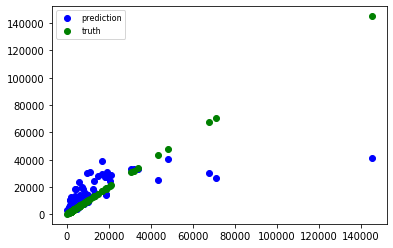

In [12]:
# Use automl metrics module
scores = metrics.compute_metrics_regression(
    pred_automl["predicted"],
    pred_automl[target_column_name],
    list(constants.Metric.SCALAR_REGRESSION_SET),
    None,
    None,
    None,
)

print("[Test data scores]\n")
for key, value in scores.items():
    print("{}:   {:.3f}".format(key, value))

# Plot outputs
test_pred = plt.scatter(pred_automl[target_column_name], pred_automl["predicted"], color="b")
test_test = plt.scatter(pred_automl[target_column_name], pred_automl[target_column_name], color="g")
plt.legend((test_pred, test_test), ("prediction", "truth"), loc="upper left", fontsize=8)
plt.show()

In [14]:
pred_automl_sub = pred_automl.loc[pred_automl.week >= max(test_df.week) - NUM_TEST_PERIODS + GAP]
mape_automl_sub = MAPE(pred_automl_sub["predicted"], pred_automl_sub["move"]) * 100
print("MAPE of forecasts obtained by AutoML in the last two weeks: " + str(mape_automl_sub))

MAPE of forecasts obtained by AutoML in the last two weeks: 124.48495443175851


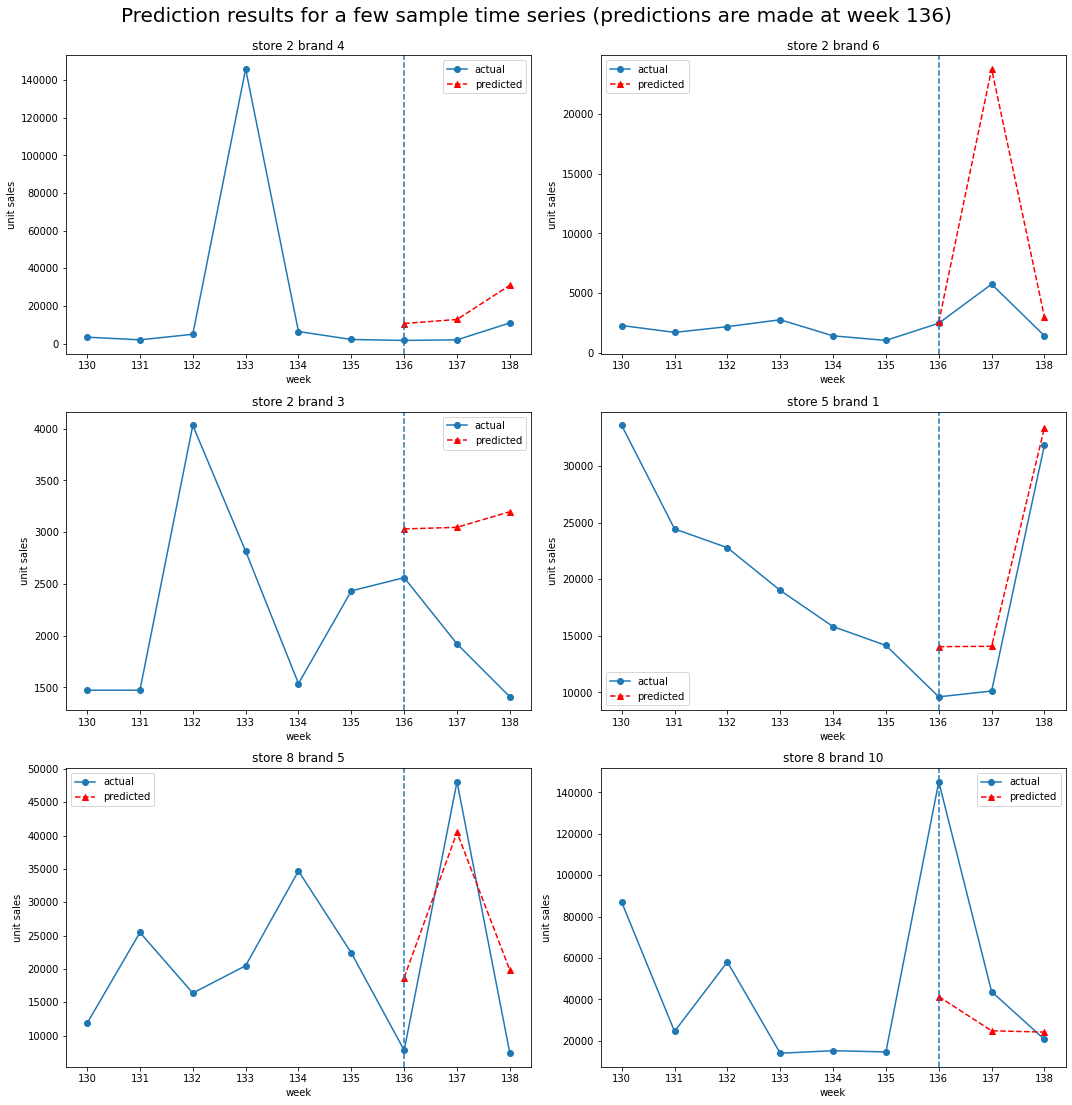

In [38]:
num_samples = 6
min_week = 130
sales = pd.read_csv(os.path.join(DATA_DIR, "yx.csv"))
sales["move"] = sales.logmove.apply(lambda x: round(math.exp(x)) if x > 0 else 0)
pred_automl["move"] = pred_automl["predicted"]

store_list = pred_automl["store"].unique()
brand_list = pred_automl["brand"].unique()

plot_predictions_with_history(
    pred_automl,
    sales,
    grain1_unique_vals=store_list,
    grain2_unique_vals=brand_list,
    time_col_name="week",
    target_col_name="move",
    grain1_name="store",
    grain2_name="brand",
    min_timestep=min_week,
    num_samples=num_samples,
    predict_at_timestep=min(pred_automl.week),
    line_at_predict_time=True,
    title="Prediction results for a few sample time series (predictions are made at week 136)",
    x_label="week",
    y_label="unit sales",
    random_seed=2,
)

## Additional Reading

\[1\] Nicolo Fusi, Rishit Sheth, and Melih Elibol. 2018. Probabilistic Matrix Factorization for Automated Machine Learning. In Advances in Neural Information Processing Systems. 3348-3357.<br>
\[2\] Azure AutoML Package Docs: https://docs.microsoft.com/en-us/python/api/azureml-train-automl/azureml.train.automl?view=azure-ml-py <br>
\[3\] Azure Automated Machine Learning Examples: https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning <br>